In [1]:
import s3fs
import datetime
import xarray as xr
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

from cartopy import crs as ccrs
import cartopy.feature as cfeature

from pathlib import Path
from PIL import Image
import os

In [2]:
fs = s3fs.S3FileSystem(anon=True)

In [3]:
products = fs.ls('noaa-goes16')

Set the date and hour for the data of interest: 

In [4]:
year = 2023
month = 3
day = 31
hour = 12

julian_day = datetime.datetime(year, month, day).strftime('%j')
print(julian_day)

090


Product chosen: ABI imager (mesoscale)

In [5]:
bucket = 'noaa-goes16'
product = 'ABI-L1b-RadM'

data_path = bucket + '/' + product + '/'  + str(year) + '/' + julian_day + '/' + str(hour).zfill(2)

files = fs.ls(data_path)

#for file in files:
#    print(file.split('/')[-1])

M1 refers to mesoscale sector 1, M6 refers to scan mode 6.

Select the start and end times within the hour selected earlier: 

In [6]:
observation_start = str(hour)+'00'
observation_end = str(hour+1)+'00'
product_name_01 = 'ABI-L1b-RadM1-M6C01' #blue vis band
product_name_07 = 'ABI-L1b-RadM1-M6C07' #SW IR band (3.9um)

matches_01 = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name_01)]
matches_07 = [file for file in files if (file.split('/')[-1].split('_')[3][8:12] >= observation_start and file.split('/')[-1].split('_')[3][8:12] <= observation_end and file.split('/')[-1].split('_')[1] == product_name_07)]


for match_07 in matches_07:
    print(match_07.split('/')[-1])
    print('Approximate file size (MB):', round((fs.size(match_07)/1.0E6), 2))

OR_ABI-L1b-RadM1-M6C07_G16_s20230901200275_e20230901200345_c20230901200388.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901201246_e20230901201316_c20230901201349.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901202246_e20230901202317_c20230901202355.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901203246_e20230901203317_c20230901203360.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901204246_e20230901204315_c20230901204365.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901205246_e20230901205318_c20230901205350.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901206246_e20230901206316_c20230901206359.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901207246_e20230901207320_c20230901207356.nc
Approximate file size (MB): 0.32
OR_ABI-L1b-RadM1-M6C07_G16_s20230901208246_e20230901208316_c20230901208340.nc
Approximate file size (MB): 0.32
O

Function to get latitude and longitude from goes fixed grid:

In [7]:
def calculate_abi_lat_lon(ds):
    
    # Read in GOES ABI fixed grid projection variables and constants
    x_coordinate_1d = ds.x  # E/W scanning angle in radians
    y_coordinate_1d = ds.y  # N/S elevation angle in radians
    projection_info = ds.goes_imager_projection  # ABI fixed grid contstants
    lon_origin = projection_info.longitude_of_projection_origin
    H = projection_info.perspective_point_height+projection_info.semi_major_axis
    r_eq = projection_info.semi_major_axis
    r_pol = projection_info.semi_minor_axis
    
    # Create 2D coordinate matrices from 1D coordinate vectors
    x_coordinate_2d, y_coordinate_2d = np.meshgrid(x_coordinate_1d, y_coordinate_1d)
    
    # Equations to calculate latitude and longitude
    lambda_0 = (lon_origin*np.pi)/180.0  
    a_var = np.power(np.sin(x_coordinate_2d),2.0) + (np.power(np.cos(x_coordinate_2d),2.0)*(np.power(np.cos(y_coordinate_2d),2.0)+(((r_eq*r_eq)/(r_pol*r_pol))*np.power(np.sin(y_coordinate_2d),2.0))))
    b_var = -2.0*H*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    c_var = (H**2.0)-(r_eq**2.0)
    r_s = (-1.0*b_var - np.sqrt((b_var**2)-(4.0*a_var*c_var)))/(2.0*a_var)
    s_x = r_s*np.cos(x_coordinate_2d)*np.cos(y_coordinate_2d)
    s_y = - r_s*np.sin(x_coordinate_2d)
    s_z = r_s*np.cos(x_coordinate_2d)*np.sin(y_coordinate_2d)
    
    lat = (180.0/np.pi)*(np.arctan(((r_eq*r_eq)/(r_pol*r_pol))*((s_z/np.sqrt(((H-s_x)*(H-s_x))+(s_y*s_y))))))
    lon = (lambda_0 - np.arctan(s_y/(H-s_x)))*(180.0/np.pi)
    
    return lat, lon

Checking out the mesoscale sector:

In [8]:
sample_01 = matches_01[3]
sample_07 = matches_07[3]

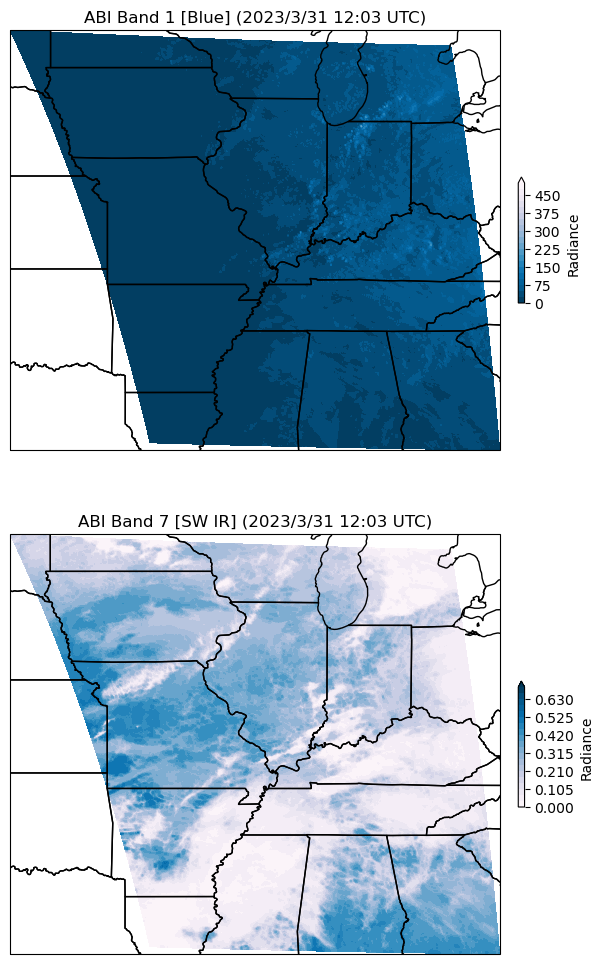

In [9]:
with fs.open(sample_01, mode='rb') as remote_file_01:
    with xr.open_dataset(remote_file_01, engine='h5netcdf') as ds_01:
        #print(ds_01)

        with fs.open(sample_07, mode='rb') as remote_file_07:
            with xr.open_dataset(remote_file_07, engine='h5netcdf') as ds_07:
                #print(ds_07)
        
                projection=ccrs.PlateCarree()
                fig,ax=plt.subplots(2, figsize=(12,12),subplot_kw={'projection': projection})
                cmap_01 = plt.cm.PuBu_r
                cmap_07 = plt.cm.PuBu
                levels_01 = np.linspace(0, 500, 21)
                levels_07 = np.linspace(0, 0.7, 21)

                lat_01, lon_01 = calculate_abi_lat_lon(ds_01)
                lat_07, lon_07 = calculate_abi_lat_lon(ds_07)
                ax[0].set_extent([np.nanmin(lon_01), np.nanmax(lon_01), np.nanmin(lat_01), np.nanmax(lat_01)])
                ax[1].set_extent([np.nanmin(lon_07), np.nanmax(lon_07), np.nanmin(lat_07), np.nanmax(lat_07)])
            
                c_01=ax[0].contourf(lon_01, lat_01, ds_01.Rad, cmap=cmap_01, extend='max', levels=levels_01)
                c_07=ax[1].contourf(lon_07, lat_07, ds_07.Rad, cmap=cmap_07, extend='max', levels=levels_07)
                clb_01=plt.colorbar(c_01, shrink=0.3, pad=0.02, ax=ax[0])
                clb_07=plt.colorbar(c_07, shrink=0.3, pad=0.02, ax=ax[1])
                clb_01.set_label('Radiance')
                clb_07.set_label('Radiance')
            
                ax[0].coastlines(resolution='50m', color='black', linewidth=1)
                ax[0].add_feature(cfeature.STATES)
                ax[1].coastlines(resolution='50m', color='black', linewidth=1)
                ax[1].add_feature(cfeature.STATES)
                
                time = sample_01.split('/')[-1][35:37] +':'+ sample_01.split('/')[-1][37:39]
                date = str(year) +'/'+ str(month) +'/'+ str(day)
                title_01 = 'ABI Band 1 [Blue] (' + date + ' ' + time + ' UTC)'
                title_07 = 'ABI Band 7 [SW IR] (' + date + ' ' + time + ' UTC)'
                ax[0].set_title(title_01)
                ax[1].set_title(title_07)
            
            #saved_file_name = 'ABI_Combo_'+str(year)+'_'+str(month)+'_'+str(day)+'_'+match.split('/')[-1][35:39]
            #fig.savefig(image_dir_combo+'/'+saved_file_name, dpi=100, bbox_inches='tight')
            
            #plt.close()

Determine the sunset and sunrise times:

In [10]:
!pip install suntime

In [11]:
from suntime import Sun
import pytz

In [12]:
time = sample_01.split('/')[-1][35:37] +':'+ sample_01.split('/')[-1][37:39]
date = str(year) +'/'+ str(month) +'/'+ str(day)
time_str = date + ' ' + time
utc_time = datetime.datetime.strptime(time_str, "%Y/%m/%d %H:%M")

In [13]:
sun = Sun(np.mean(lat_01), np.mean(lon_01))
abd = utc_time.date()
sr = sun.get_sunrise_time(abd)
#--- This line may need to be adjusted to work for different seasons
ss = sun.get_sunset_time(abd) + datetime.timedelta(days=1)

print(ss)
print(sr)
# if utc_time < ss:
#     print('daytime')
# else:
#     print('nighttime')

2023-04-01 00:17:00+00:00
2023-03-31 11:43:00+00:00


Plot using the sun times to switch data source: 

In [14]:
image_dir = 'ABI_Combo_'+str(year)+'_'+str(month)+'_'+str(day)

if not os.path.exists(image_dir):
    os.makedirs(image_dir)

In [15]:
for i in range(len(matches_01)):
    with fs.open(matches_01[i], mode='rb') as remote_file_01:
        with xr.open_dataset(remote_file_01, engine='h5netcdf') as ds_01:
    
            with fs.open(matches_07[i], mode='rb') as remote_file_07:
                with xr.open_dataset(remote_file_07, engine='h5netcdf') as ds_07:
            
                    projection=ccrs.PlateCarree()
                    fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
                    
                    time = matches_01[i].split('/')[-1][35:37] +':'+ matches_01[i].split('/')[-1][37:39]
                    date = str(year) +'/'+ str(month) +'/'+ str(day)
                    time_str = date + ' ' + time
                    utc_time = datetime.datetime.strptime(time_str, "%Y/%m/%d %H:%M")
    
                    cmap_01 = plt.cm.PuBu_r
                    cmap_07 = plt.cm.PuBu
                    lat_01, lon_01 = calculate_abi_lat_lon(ds_01)
                    lat_07, lon_07 = calculate_abi_lat_lon(ds_07)
                    
                    ax.set_extent([np.nanmin(lon_01), np.nanmax(lon_01), np.nanmin(lat_01), np.nanmax(lat_01)])

                    desired_timezone = pytz.timezone('UTC')
                    utc_time = desired_timezone.localize(utc_time)
                    
                    #--- Currently just manually setting the sunset and sunrise
                    
                    if utc_time.time() < datetime.time(0) or utc_time.time() > datetime.time(12):
                        c_01=ax.contourf(lon_01, lat_01, ds_01.Rad, cmap=cmap_01, extend='max', levels=levels_01)
                        clb_01=plt.colorbar(c_01, shrink=0.3, pad=0.02, ax=ax)
                        clb_01.set_label('Radiance')
                        title = 'ABI Combo Daytime (' + date + ' ' + time + ' UTC)'
    
                    else:
                        c_07=ax.contourf(lon_07, lat_07, ds_07.Rad, cmap=cmap_07, extend='max', levels=levels_07)
                        clb_07=plt.colorbar(c_07, shrink=0.3, pad=0.02, ax=ax)
                        clb_07.set_label('Radiance')
                        title = 'ABI Combo Nighttime (' + date + ' ' + time + ' UTC)'
                        
                
                    ax.coastlines(resolution='50m', color='black', linewidth=1)
                    ax.add_feature(cfeature.STATES)
                    ax.set_title(title)

                    saved_file_name = 'ABI_Combo_'+str(year)+'_'+str(month)+'_'+str(day)+'_'+matches_01[i].split('/')[-1][35:39]
                    fig.savefig(image_dir+'/'+saved_file_name, dpi=100, bbox_inches='tight')
            
                    plt.close()
            

Create animation: 

In [16]:
def create_pillow_animation(file_list, save_path, save_name, duration, loop):
    frames = [Image.open(file) for file in file_list]

    frames[0].save((save_path / save_name).as_posix() + '.gif', format='GIF', append_images=frames[1:], 
                    save_all=True, duration=duration, loop=loop)
    print('Animation done!')

In [17]:
graphics_files = sorted(Path.cwd().glob(image_dir+'/ABI_*.png'))

In [18]:
pil_duration = 100  # Time in ms between frames (e.g., 1000 ms = 1 second between frames)
pil_loop = 0  # No. times animation repeats (e.g., 0: loops continuously; 2: runs 3 times then stops)
animation_save_path = Path.cwd()  # Directory where animation file will be saved
date = str(year)+'_'+str(month)+'_'+str(day)
animation_save_name = 'ABI_Combo_'+date+'_animation'  # Name for saved animation .gif file

graphics_files = sorted(Path.cwd().glob(image_dir+'/ABI_*.png'))

# Create the animation using the function defined previously
create_pillow_animation(graphics_files, animation_save_path, animation_save_name, pil_duration, pil_loop)

Animation done!
